# Claim2Title

This notebook will investigate whether I can use a sequence to sequence model to generate patent specification title from patent claim text.

## Getting the Data

First we need a source of say ~ 10,000 titles and claims. We'll concentrate on G06 as crossing the streams of chemistry and computing results in some funky chimeras.

In [1]:
# imports
import os, pickle
from patentdata.models.lib.utils import clean_characters
from keras.preprocessing import text
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Get the claim 1 and classificationt text

PIK = "claim_and_title.data"

if os.path.isfile(PIK):
    with open(PIK, "rb") as f:
        print("Loading data")
        data = pickle.load(f)
        print("{0} claims and titles loaded".format(len(data)))

Loading data
12000 claims and titles loaded


In [3]:
data[1]

('\n1. An image forming apparatus, comprising: \nsetting section to be used by a user for setting, as a copying mode, a writing space mode in which a document image in a preset number are printed on a half of a single paper sheet, thus forming a writing space on the other half of the paper sheet, and \nimage forming section for printing the document image in the preset number on a half of a single paper sheet when the writing space mode has been set as a copying mode. \n\n',
 'Image forming apparatus having writing space mode')

In [4]:
# Check for and remove 'cancelled' claims
data = [d for d in data if '(canceled)' not in d[0]]

print("There are now {0} claims after filtering out cancelled claims".format(len(data)))

There are now 11428 claims after filtering out cancelled claims


In [5]:
# Clean the characters in the data to use a reduced set of printable characters
# There is a function in patentdata to do this

data = [(clean_characters(d[0]), clean_characters(d[1])) for d in data]

We need a stop character on our output. We can add a "\n" new-line character to the end of each title and use this. We also need a start character. Taking a lead from the Keras tutorial we can use "\t" as a start symbol.

In [6]:
data = [(d[0], "\t" + d[1]+ "\n") for d in data]
print(data[0])

('\n1. A mail management method for retrieving and adding e-mail messages to an existing business software application database, comprising: \nscanning a header portion of each message to locate an identification; \ncomparing the identification with a plurality of identifications stored in a business software application database to identify a matching identification; \nadding the message with the matching identification into the business software application database wherein the message is associated with the matching identification; and \ncreating a Task associated with the message that is linked to the business software application database. \n\n', '\tMail management system and method\n')


Can we cascade RNN cells as per here: http://www.xiaodanzhu.com/publications/zhu_icml_15.pdf?

In [7]:
length = max([len(d[0]) for d in data])
print("Our longest claim is {0} characters long.".format(length))

Our longest claim is 23654 characters long.


In [8]:
length = max([len(d[1]) for d in data])
print("Our longest title is {0} characters long.".format(length))

Our longest title is 399 characters long.


### Preparing Titles

Let's use characters on the output. The title will be all capitals anyway and will likely not contain any punctuation.

In [7]:
# lower = true doesn't seem to work at the character level
t_title = text.Tokenizer(char_level=True)
Y_texts = [d[1].upper() for d in data]
t_title.fit_on_texts(Y_texts)

In [8]:
Y_texts

['\tMAIL MANAGEMENT SYSTEM AND METHOD\n',
 '\tIMAGE FORMING APPARATUS HAVING WRITING SPACE MODE\n',
 '\tHARDWARE RECOVERY IN A MULTI-THREADED ARCHITECTURE\n',
 '\tPOWER SUPPLY APPARATUS OF MOBILE TERMINAL\n',
 '\tADAPTIVE CUSTOMER DRIVEABILITY MODULE\n',
 '\tDATA STRUCTURE SUPPORTING SESSION TIMER AND VARIABLE AGING FUNCTION INCLUDING SELF ADJUSTABLE 2MSL\n',
 '\tDEEP RESISTIVITY TRANSIENT METHOD FOR MWD APPLICATIONS USING ASYMPTOTIC FILTERING\n',
 '\tMETHOD, COMPUTER PROGRAM PRODUCT, AND SYSTEM FOR RISK MANAGEMENT\n',
 '\tSYSTEM AND METHOD FOR PERFORMING AUTO-FOCUSED TOMOSYNTHESIS\n',
 '\tMETHOD AND SYSTEM FOR TOOLESS KEYBOARD ASSEMBLY INTO AN INFORMATION HANDLING SYSTEM HOUSING\n',
 '\tSYSTEMS AND METHODS FOR FORWARDING DATA UNITS IN A COMMUNICATIONS NETWORK\n',
 '\tROTATING PRISM COMPONENT INSPECTION SYSTEM\n',
 '\tSYSTEM AND METHOD FOR INTEGRATING SPREADSHEETS AND WORD PROCESSING TABLES\n',
 '\tREAL ESTATE BUSINESS METHOD AND SYSTEM INTEGRATING MULTI-LEVEL NETWORK MARKETING, FRANCH

In [11]:
t_title.word_index

{'\t': 20,
 '\n': 19,
 ' ': 1,
 '"': 45,
 '&': 40,
 "'": 36,
 '(': 33,
 ')': 34,
 '+': 52,
 ',': 25,
 '-': 27,
 '.': 38,
 '/': 32,
 '0': 41,
 '1': 39,
 '2': 37,
 '3': 35,
 '4': 46,
 '5': 50,
 '6': 43,
 '7': 51,
 '8': 44,
 '9': 48,
 ':': 42,
 ';': 53,
 'A': 3,
 'B': 23,
 'C': 12,
 'D': 10,
 'E': 2,
 'F': 17,
 'G': 14,
 'H': 18,
 'I': 6,
 'J': 31,
 'K': 26,
 'L': 15,
 'M': 11,
 'N': 5,
 'O': 7,
 'P': 13,
 'Q': 30,
 'R': 8,
 'S': 9,
 'T': 4,
 'U': 16,
 'V': 22,
 'W': 24,
 'X': 28,
 'Y': 21,
 'Z': 29,
 '[': 47,
 ']': 49}

In [12]:
t_title.word_counts

OrderedDict([('\t', 11429),
             ('M', 29532),
             ('A', 55122),
             ('I', 50657),
             ('L', 18595),
             (' ', 87177),
             ('N', 51066),
             ('G', 18954),
             ('E', 66374),
             ('T', 54648),
             ('S', 41054),
             ('Y', 9428),
             ('D', 31341),
             ('H', 13461),
             ('O', 50321),
             ('\n', 11434),
             ('F', 14484),
             ('R', 44172),
             ('P', 19110),
             ('U', 16235),
             ('V', 7093),
             ('W', 3686),
             ('C', 27102),
             ('-', 2213),
             ('B', 5414),
             ('J', 492),
             ('2', 27),
             (',', 2455),
             ('K', 2247),
             ('X', 982),
             ('Q', 619),
             ('Z', 941),
             ('/', 209),
             ('6', 5),
             ('(', 92),
             (')', 92),
             ('"', 4),
             ("'", 32),
         

We can probably limit to the top 34 tokens (i.e. of length 35 including 0).

In [9]:
Y_seqs = t_title.texts_to_sequences(Y_texts)

In [10]:
# Setting vocabulary lengths
X_vocab_len = 10000
y_vocab_len = 35

In [11]:
# Now let's replace any integer > 33 with a space (1)
Y_seq_filtered = list()
for Y in Y_seqs:
    Y_seq_filtered.append([y if y < y_vocab_len else 1 for y in Y])
Y_seqs = Y_seq_filtered

In [11]:
print("Our maximum char integer in the title is {0}.".format(max([max(y) for y in Y_seqs])))

Our maximum char integer in the title is 34.


### Preparing Claims

In [12]:
t_claim = text.Tokenizer(
                num_words=X_vocab_len, 
                filters='1.:;\n',
                lower=True,
                split=" ",
                char_level=False
)
X_texts = [d[0] for d in data]
t_claim.fit_on_texts(X_texts)
X_seqs = t_claim.texts_to_sequences(X_texts)

In [13]:
print("Our input sequences (claims) have a vocabulary of {0} words".format(max([v for k, v in t_claim.word_index.items()])))
print("Our output sequences (titles) have a vocabulary of {0} words".format(max([v for k, v in t_title.word_index.items()])))

Our input sequences (claims) have a vocabulary of 25871 words
Our output sequences (titles) have a vocabulary of 53 words


We have limited our claims to 10000 words and our characters to 33 characters + 0.

In [13]:
print(X_texts[0], X_seqs[0])


1. A mail management method for retrieving and adding e-mail messages to an existing business software application database, comprising: 
scanning a header portion of each message to locate an identification; 
comparing the identification with a plurality of identifications stored in a business software application database to identify a matching identification; 
adding the message with the matching identification into the business software application database wherein the message is associated with the matching identification; and 
creating a Task associated with the message that is linked to the business software application database. 

 [2, 964, 104, 25, 6, 472, 5, 735, 1137, 576, 4, 10, 1041, 265, 130, 69, 583, 13, 674, 2, 1725, 78, 3, 29, 100, 4, 1803, 10, 169, 321, 1, 169, 17, 2, 23, 3, 4723, 85, 7, 2, 265, 130, 69, 86, 4, 380, 2, 392, 169, 735, 1, 100, 17, 1, 392, 169, 73, 1, 265, 130, 69, 86, 28, 1, 100, 19, 41, 17, 1, 392, 169, 5, 234, 2, 348, 41, 17, 1, 100, 26, 19, 1124, 4,

In [14]:
print(Y_texts[0], Y_seqs[0])

	MAIL MANAGEMENT SYSTEM AND METHOD
 [20, 11, 3, 6, 15, 1, 11, 3, 5, 3, 14, 2, 11, 2, 5, 4, 1, 9, 21, 9, 4, 2, 11, 1, 3, 5, 10, 1, 11, 2, 4, 18, 7, 10, 19]


In [21]:
t_claim.word_index

{'systematically': 15723,
 'p<m': 19141,
 'maximizes': 9422,
 'predicating': 20667,
 'center,': 3318,
 'rank,': 11470,
 'remain': 6510,
 'vapor': 7567,
 'intra-pair': 15012,
 'lawful': 25066,
 'multipurpose': 17838,
 'pending': 2422,
 'uwb': 14267,
 'accomplish': 6123,
 'fax': 10589,
 '[v]=<t': 20988,
 'clasps,': 19416,
 'tri-state': 20084,
 'ongoing': 7244,
 'tuples,': 9329,
 '"up"': 15230,
 'elastomeric': 15282,
 '(ste)': 22418,
 'aborting': 10821,
 'switches': 2106,
 'approaches': 5361,
 'spreadsheet': 3506,
 '2m-': 10108,
 'subsetting-optimization': 11907,
 'effectuate': 8439,
 're-starting': 14969,
 'examinations': 10642,
 're-executing': 9203,
 'post-trade': 9659,
 'construction,': 14742,
 'milk,': 20214,
 'tx,': 15364,
 'subscription': 2413,
 'cookies': 7257,
 'cb2': 12840,
 'clouds': 9819,
 'lippmann-schwinger': 15675,
 'peripherals': 6087,
 'drop-dead': 25806,
 'circular': 2078,
 'asymmetry': 8612,
 'jackpot': 3517,
 'weighting': 2237,
 'leasing': 7402,
 'non-threshold': 25467

Let's have a look at our sequence length distributions.

Our longest sequence is 3338 tokens long.


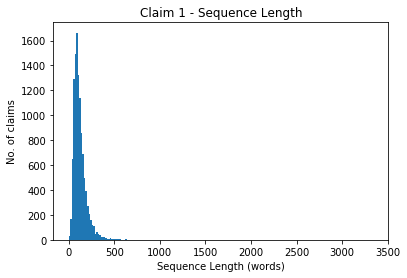

In [22]:
X_length = [len(x) for x in X_seqs]
max_length = max(X_length)
print("Our longest sequence is {0} tokens long.".format(max_length))

bins = np.linspace(0, max_length, 200)
plt.hist(X_length, bins)
plt.title('Claim 1 - Sequence Length')
plt.ylabel('No. of claims');
plt.xlabel('Sequence Length (words)');

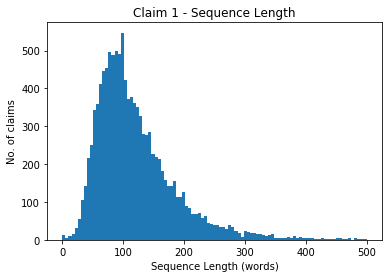

In [23]:
# Let's zoom in on 0 to 500
bins = np.linspace(0, 500, 100)
plt.hist(X_length, bins)
plt.title('Claim 1 - Sequence Length')
plt.ylabel('No. of claims');
plt.xlabel('Sequence Length (words)');

Let's limit our sequence length to 300 on our input.

Our longest sequence is 399 tokens long.


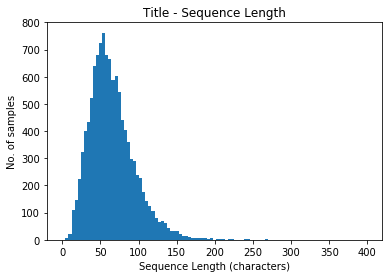

In [24]:
Y_length = [len(y) for y in Y_seqs]
max_y_length = max(Y_length)
print("Our longest sequence is {0} tokens long.".format(max_y_length))

bins = np.linspace(0, max_y_length, 100)
plt.hist(Y_length, bins)
plt.title('Title - Sequence Length')
plt.ylabel('No. of samples');
plt.xlabel('Sequence Length (characters)');

Let's limit to 150 on our output.  

So we can pad our input and output sequences, limiting to 300 on the input and 150 on the output.

In [15]:
# Setting maximum sequence lengths
X_max_len = 300
y_max_len = 150

In [16]:
X = pad_sequences(X_seqs, maxlen=X_max_len)
Y = pad_sequences(Y_seqs, maxlen=y_max_len)

In [17]:
print("Our X data has shape {0} and our Y data has shape {1}".format(X.shape, Y.shape))

Our X data has shape (11428, 300) and our Y data has shape (11428, 150)


## Building the Sequence to Sequence Model

In [18]:
class Claims2Title:
    
    def __init__(
        self, 
        seqout_dict,
        seqin_max_len=300, 
        seqout_max_len=150, 
        seqin_vocab_len=10000, 
        seqout_vocab_len=35,
        hidden_size=100,
        filepath="weights-best.hdf5"
    ):
        """ Initialise."""
        self.filepath = filepath
        self.batch_size = 64
        self.seqin_max_len = seqin_max_len
        self.seqout_max_len = seqout_max_len
        self.seqin_vocab_len = seqin_vocab_len
        self.seqout_vocab_len = seqout_vocab_len
        self.hidden_size = hidden_size
        
        self.target_char_index = seqout_dict
        # Generate a reverse dictionary for our title characters
        self.reverse_target_char_index = dict(
            (i, char) for char, i in seqout_dict.items()
        )
        self.build_model()
    
    def build_model(self, print_summary=False):
        """ Build keras model."""
        # Define an input sequence and process it.
        inputs = Input(shape=(self.seqin_max_len,), dtype='int32', name='main_input')
        embedding = Embedding(
            input_dim=self.seqin_vocab_len, 
            output_dim=1000, 
            input_length=self.seqin_max_len, 
            mask_zero=True
        )(inputs)
        encoder_outputs, state_h, state_c = LSTM(self.hidden_size, return_state=True)(embedding)
        # We discard `encoder_outputs` and only keep the states.
        encoder_states = [state_h, state_c]

        # Set up the decoder, using `encoder_states` as initial state.
        decoder_inputs = Input(shape=(None, self.seqout_vocab_len))
        # We set up our decoder to return full output sequences,
        # and to return internal states as well. We don't use the 
        # return states in the training model, but we will use them in inference.
        decoder_lstm = LSTM(self.hidden_size, return_sequences=True, return_state=True)
        decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
        decoder_dense = Dense(self.seqout_vocab_len, activation='softmax')
        decoder_outputs = decoder_dense(decoder_outputs)

        # Define the model that will turn
        # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
        self.model = Model([inputs, decoder_inputs], decoder_outputs)
        
        # Define decoder models
        # Define sampling models
        self.encoder_model = Model(inputs, encoder_states)

        decoder_state_input_h = Input(shape=(self.hidden_size,))
        decoder_state_input_c = Input(shape=(self.hidden_size,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
        decoder_outputs, state_h, state_c = decoder_lstm(
            decoder_inputs, initial_state=decoder_states_inputs)
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)
        self.decoder_model = Model(
            [decoder_inputs] + decoder_states_inputs,
            [decoder_outputs] + decoder_states)
        
        self.model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        try:
            # load weights
            self.model.load_weights(self.filepath)
            print("Loaded weights")
        except:
            print("No existing weights found")
        if print_summary:
            print("Training Model:\n")
            print(self.model.summary())
            print("Sampling Encoder Model:\n")
            print(self.encoder_model.summary())
            print("Sampling Decoder Model:\n")
            print(self.decoder_model.summary())
        
    def to_one_hot(self, output_seq):
        """ Convert a sequence of integers to a sequence of one-hot vectors."""
        one_hot_in = np.zeros((len(output_seq), self.seqout_max_len, self.seqout_vocab_len))
        one_hot_out = np.zeros((len(output_seq), self.seqout_max_len, self.seqout_vocab_len))
        for i, sequence in enumerate(output_seq):
            for t, word_int in enumerate(sequence):
                one_hot_in[i, t, word_int] = 1
                if t > 0:
                    # Shift decoder target get so it is one ahead
                    one_hot_out[i, t-1, word_int] = 1
        return one_hot_in, one_hot_out
        
    def train(self, epochs, X, Y):
        """ Train the Training Model."""
        
        Y_one_hot_in, Y_one_hot_out = self.to_one_hot(Y)
        
        try:
            # load weights
            self.model.load_weights(self.filepath)
            print("Loaded weights")
        except:
            print("No existing weights found")
            
        checkpoint = ModelCheckpoint(self.filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        callbacks_list = [checkpoint]
        history = self.model.fit([X, Y_one_hot_in], Y_one_hot_out,
          batch_size=self.batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=callbacks_list
          )
        return history
        
    def sample(self, preds, temperature=1.0):
        # helper function to sample an index from a probability array
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, preds, 1)
        return np.argmax(probas)
        
    def decode_sequence(self, input_seq, temp=1.0):
        # Encode the input as state vectors.
        states_value = self.encoder_model.predict(input_seq)

        # Generate empty target sequence of length 1.
        target_seq = np.zeros((1, 1, self.seqout_vocab_len))
        # Populate the first character of target sequence with the start character.
        target_seq[0, 0, self.target_char_index['\t']] = 1.

        # Sampling loop for a batch of sequences
        # (to simplify, here we assume a batch of size 1).
        stop_condition = False
        decoded_sentence = ''
        while not stop_condition:
            output_tokens, h, c = self.decoder_model.predict(
                [target_seq] + states_value)

            # Sample a token
            #sampled_token_index = np.argmax(output_tokens[0, -1, :])
            sampled_token_index = self.sample(output_tokens[0, -1, :], temp)
            #print(sampled_token_index)
            sampled_char = self.reverse_target_char_index[sampled_token_index]
            decoded_sentence += sampled_char

            # Exit condition: either hit max length
            # or find stop character.
            if (sampled_char == '\n' or
               len(decoded_sentence) > y_max_len):
                stop_condition = True

            # Update the target sequence (of length 1).
            target_seq = np.zeros((1, 1, self.seqout_vocab_len))
            target_seq[0, 0, sampled_token_index] = 1.

            # Update states
            states_value = [h, c]

        return decoded_sentence
    

In [19]:
c2t = Claims2Title(t_title.word_index, hidden_size=300, filepath="300_hidden.hd5")

Loaded weights


In [21]:
c2t.train(1, X, Y)

Loaded weights
Train on 9142 samples, validate on 2286 samples
Epoch 1/1
9142/9142 [==============================] - 4757s - loss: 0.3803 - acc: 0.8803 - val_loss: 0.4298 - val_acc: 0.8680


In [27]:
c2t.decode_sequence(X[-1].reshape(1,300), 0.5)

8
3
14
16
9
1
3
5
10
1
11
2
4
18
7
10
1
17
7
8
1
12
7
5
4
8
7
15
15
6
5
14
1
4
18
2
1
9
3
11
2
25
1
3
5
10
1
3
5
3
15
21
9
6
9
1
7
17
1
3
5
1
2
15
2
12
4
8
7
5
6
12
1
3
13
13
15
6
12
3
4
6
7
5
1
13
8
7
14
8
3
11
11
6
5
14
1
6
5
1
3
5
1
7
5
15
6
5
2
1
13
3
8
4
6
4
6
7
5
2
1
8
2
9
7
16
8
12
2
9
19


'RAGUS AND METHOD FOR CONTROLLING THE SAME, AND ANALYSIS OF AN ELECTRONIC APPLICATION PROGRAMMING IN AN ONLINE PARTITIONE RESOURCES\n'

We need to generate some completely separate test data.

In [23]:
Y_texts[-1]

'\tMETHOD, SYSTEM AND MOBILE DEVICE FOR IMPLEMENTING A SERVERLESS PRESENCE SYSTEM\n'

In [45]:
c2t.decode_sequence(X[5].reshape(1,300))

'ARATCESTING AND PROGRAM AND METHOD FOR PROVIDING A COMPUTER PROGRAM AND METHOD FOR PROVIDING A COMPUTER PROGRAM\n'

In [46]:
Y_texts[5]

'\tDATA STRUCTURE SUPPORTING SESSION TIMER AND VARIABLE AGING FUNCTION INCLUDING SELF ADJUSTABLE 2MSL\n'

In [72]:
c2t.decode_sequence(X[15].reshape(1,300))

KeyError: 0

I think we need to adjust the temperature of our sampling - the output is getting stuck in regular patterns. Here is an explanation of temperature - https://stats.stackexchange.com/questions/255223/the-effect-of-temperature-in-temperature-sampling.

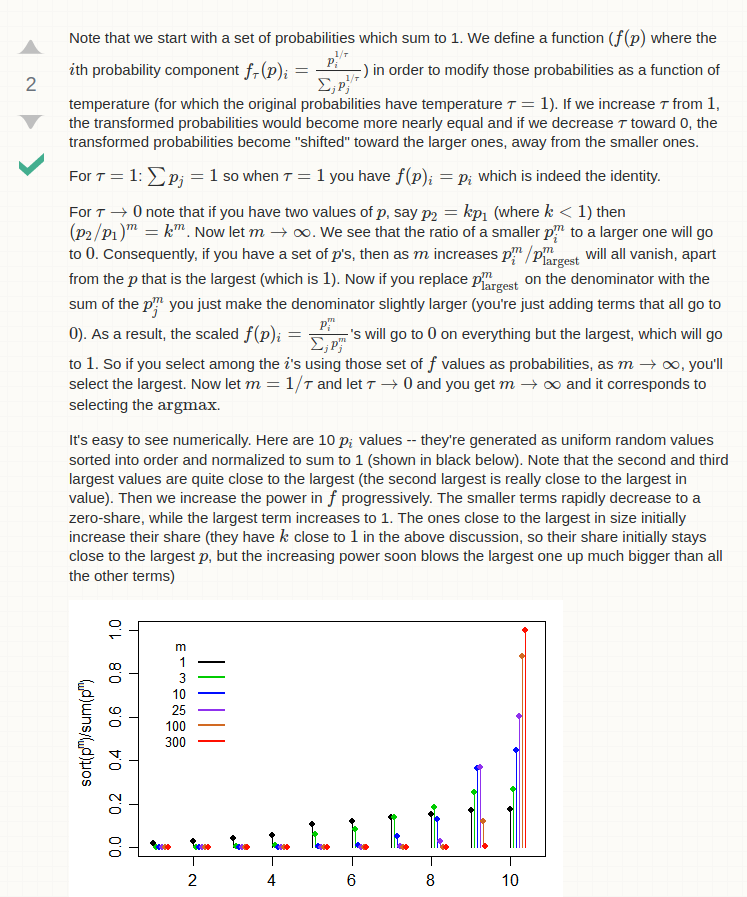

In [62]:
for temp in [0.1, 0.3, 0.6, 0.9]:
    for sent_i in [5, 150, 350, 5000]:
        print(c2t.decode_sequence(X[sent_i].reshape(1,300), temp), "\n")
        print(Y_texts[sent_i], "\n")
        print("---")
    print("====")

KeyError: 0

In [63]:
for temp in [0.1, 0.3, 0.6, 0.9]:
    print(temp)

0.1
0.3
0.6
0.9


In [65]:
print(c2t.decode_sequence(X[1].reshape(1,300), 0.1), "\n")

KeyError: 0